# Multi CPUS/GPUs support with Horovod

> **Warning** 
> The use  mutli-GPU is under developpement and hasn't been thoroughly tested yet. Proceed with caution !

QMC simulations can easily be parallelized by using multiple ressources to sample the wave function. Each walker is indenpendent of the other ones and therefore multiple compute node can be used in parallel to obtain more samples. Each node can alsu use GPUs is they are available. We demonstrate here how to use the library `Horovod` (https://github.com/horovod/horovod) to leverage large compute ressources for QMC.

Let's first create a simple system

In [3]:
import torch
from torch import optim
from qmctorch.scf import Molecule
from qmctorch.wavefunction import SlaterJastrow
from qmctorch.sampler import Metropolis
from qmctorch.utils import (plot_energy, plot_data)
mol = Molecule(atom='H 0. 0. 0; H 0. 0. 1.', unit='bohr', redo_scf=True)

INFO:QMCTorch|  ____    __  ______________             _
INFO:QMCTorch| / __ \  /  |/  / ___/_  __/__  ________/ /  
INFO:QMCTorch|/ /_/ / / /|_/ / /__  / / / _ \/ __/ __/ _ \ 
INFO:QMCTorch|\___\_\/_/  /_/\___/ /_/  \___/_/  \__/_//_/ 
INFO:QMCTorch|
INFO:QMCTorch| SCF Calculation
INFO:QMCTorch|  Removing H2_pyscf_sto-3g.hdf5 and redo SCF calculations
INFO:QMCTorch|  Running scf  calculation
converged SCF energy = -1.06599946214331
INFO:QMCTorch|  Molecule name       : H2
INFO:QMCTorch|  Number of electrons : 2
INFO:QMCTorch|  SCF calculator      : pyscf
INFO:QMCTorch|  Basis set           : sto-3g
INFO:QMCTorch|  SCF                 : HF
INFO:QMCTorch|  Number of AOs       : 2
INFO:QMCTorch|  Number of MOs       : 2
INFO:QMCTorch|  SCF Energy          : -1.066 Hartree


Let's see if GPUs are available

In [4]:
use_gpu = torch.cuda.is_available()

In [5]:
wf = SlaterJastrow(mol, cuda=use_gpu).gto2sto()
sampler = Metropolis(nwalkers=100, nstep=500, step_size=0.25,
                     nelec=wf.nelec, ndim=wf.ndim,
                     init=mol.domain('atomic'),
                     move={'type': 'all-elec', 'proba': 'normal'},
                     cuda=use_gpu)

INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 2
INFO:QMCTorch|  Configurations      : ground_state
INFO:QMCTorch|  Number of confs     : 1
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 18
INFO:QMCTorch|  Cuda support        : False
INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 100
INFO:QMCTorch|  Number of steps     : 500
INFO:QMCTorch|  Step size           : 0.25
INFO:QMCTorch|  Thermalization steps: -1
INFO:QMCTorch|  Decorelation steps  : 1
INFO:QMCTorch|  Walkers init pos    : atomic
INFO:QMCTorch|  Move type           : all-elec
INFO:QMCTorch|  Move proba          : normal


In [7]:
lr_dict = [{'params': wf.jastrow.parameters(), 'lr': 3E-3},
           {'params': wf.ao.parameters(), 'lr': 1E-6},
           {'params': wf.mo.parameters(), 'lr': 1E-3},
           {'params': wf.fc.parameters(), 'lr': 2E-3}]
opt = optim.Adam(lr_dict, lr=1E-3)

A dedicated QMCTorch Solver has been developped to handle multiple GPU. To use this solver simply import it
and use is as the normal solver and only a few modifications are required to use horovod :

In [8]:
import horovod.torch as hvd
from qmctorch.solver import SolverSlaterJastrowHorovod

hvd.init()
if torch.cuda.is_available():
    torch.cuda.set_device(hvd.rank())
    
solver = SolverSlaterJastrowHorovod(wf=wf, sampler=sampler,
                                    optimizer=opt,
                                    rank=hvd.rank())

INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis
INFO:QMCTorch|  Optimizer           : Adam


INFO:QMCTorch|
INFO:QMCTorch|  Distributed Optimization on 1 process
INFO:QMCTorch|   - Process 0 using 100 walkers
INFO:QMCTorch|
INFO:QMCTorch|  Optimization
INFO:QMCTorch|  Task                :
INFO:QMCTorch|  Number Parameters   : 2
INFO:QMCTorch|  Number of epoch     : 250
INFO:QMCTorch|  Batch size          : 100
INFO:QMCTorch|  Loss function       : energy
INFO:QMCTorch|  Clip Loss           : False
INFO:QMCTorch|  Gradients           : auto
INFO:QMCTorch|  Resampling mode     : update
INFO:QMCTorch|  Resampling every    : 1
INFO:QMCTorch|  Resampling steps    : 50
INFO:QMCTorch|  Output file         : H2_pyscf_sto-3g_QMCTorch.hdf5
INFO:QMCTorch|  Checkpoint every    : None
INFO:QMCTorch|


INFO:QMCTorch|  Sampling: 100%|██████████| 50/50 [00:00<00:00, 701.10it/s]

INFO:QMCTorch|   Acceptance rate     : 64.62 %
INFO:QMCTorch|   Timing statistics   : 682.47 steps/sec.
INFO:QMCTorch|   Total Time          : 0.07 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 0


INFO:QMCTorch|  energy   : -1.116875 +/- 0.080220
INFO:QMCTorch|  variance : 0.802197
INFO:QMCTorch|  epoch done in 0.22 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 1
INFO:QMCTorch|  energy   : -1.108158 +/- 0.081484
INFO:QMCTorch|  variance : 0.814835
INFO:QMCTorch|  epoch done in 0.21 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 2
INFO:QMCTorch|  energy   : -1.119915 +/- 0.079649
INFO:QMCTorch|  variance : 0.796494
INFO:QMCTorch|  epoch done in 0.21 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 3
INFO:QMCTorch|  energy   : -1.374136 +/- 0.241812
INFO:QMCTorch|  variance : 2.418123
INFO:QMCTorch|  epoch done in 0.21 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 4
INFO:QMCTorch|  energy   : -1.146251 +/- 0.125630
INFO:QMCTorch|  variance : 1.256302
INFO:QMCTorch|  epoch done in 0.18 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 5
INFO:QMCTorch|  energy   : -1.054188 +/- 0.054974
INFO:QMCTorch|  variance : 0.549737
INFO:QMCTorch|  epoch done in 0.19 sec.
INFO:QMCTorch|
INFO:QMCTorch|  epoch 6
INFO:QMCTo

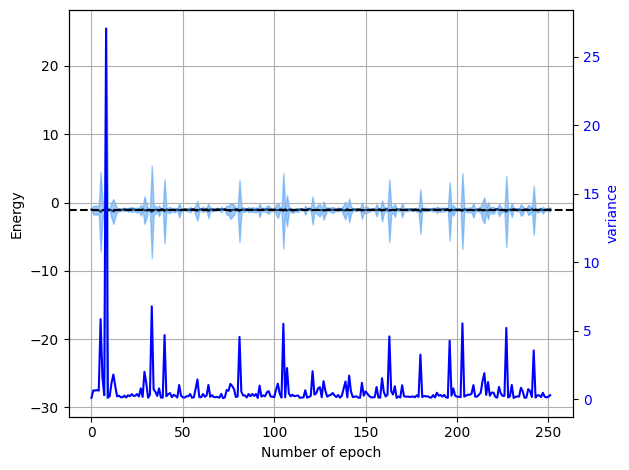

KeyError: 'jastrow.weight'

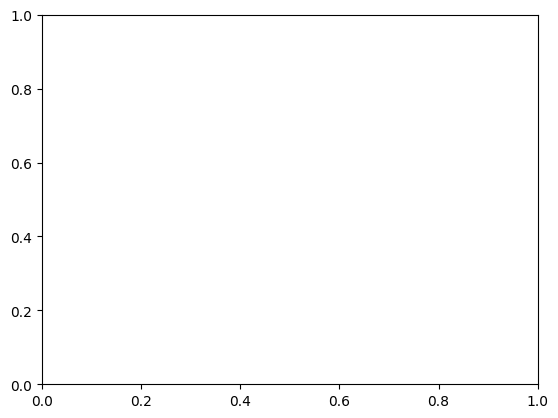

In [10]:

solver.configure(track=['local_energy'], freeze=['ao', 'mo'],
                loss='energy', grad='auto',
                ortho_mo=False, clip_loss=False,
                resampling={'mode': 'update',
                            'resample_every': 1,
                            'nstep_update': 50})

# optimize the wave function
obs = solver.run(250)

if hvd.rank() == 0:
    plot_energy(obs.local_energy, e0=-1.1645, show_variance=True)
    plot_data(solver.observable, obsname='jastrow.weight')

As you can see some classes need the rank of the process when they are defined. This is simply
to insure that only the master process generates the HDF5 files containing the information relative to the calculation.

## Running parallel calculations

It is currently difficult to use Horovod on mutliple node through a jupyter notebook. To do so, one should have a python file with all the code and execute the code  with the following command

```
horovodrun -np 2 python <example>.py
```

See the horovod documentation for more details : https://github.com/horovod/horovod


This solver distribute the `Nw` walkers over the `Np` process . For example specifying 2000 walkers
and using 4 process will lead to each process using only 500 walkers. During the optimizaiton of the wavefunction
each process will compute the gradients of the variational parameter using their local 500 walkers.
The gradients are then averaged over all the processes before the optimization step takes place. This data parallel
model has been greatly succesfull in machine learning applications (http://jmlr.org/papers/volume20/18-789/18-789.pdf)

A complete example can found in `qmctorch/docs/example/horovod/h2.py`